# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 

# using the SQL Table to read data.
import mysql.connector
con=mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="Mother9922*",
    database='data1'
    )

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80667, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,ABXLMWJIXXAIN,B000LQOCH0,"Natalia Corres ""Natalia Corres""",1219017600,4,This is a confection that has been around a fe...,3
1,A395BORC6FGVXV,B000UA0QIQ,Karl,1307923200,2,If you are looking for the secret ingredient i...,3
2,A1UQRSCLF8GW1T,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",1350777600,5,Great taffy at a great price. There was a wid...,2
3,A1SP2KVKFXXRU1,B006K2ZZ7K,David C. Sullivan,1340150400,5,This saltwater taffy had great flavors and was...,2
4,A1MZYO9TZK0BBI,B000E7L2R4,R. James,1322006400,5,Right now I'm mostly just sprouting this so my...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
18816,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393061

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164
This is a very good snack that I feel great about offering my 10 month old.  She can easily  pick up the small pieces and definitely enjoys the apple cinnamon taste.  My 5 year old loves them as well!  I would definitely recommend these to anyone with small (or larger) kids.  :)
These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with peop

In [15]:
# remove urls from text python:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164


In [16]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

262-TRIAL-Got a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with 2 buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us.. 164
This is a very good snack that I feel great about offering my 10 month old.  She can easily  pick up the small pieces and definitely enjoys the apple cinnamon taste.  My 5 year old loves them as well!  I would definitely recommend these to anyone with small (or larger) kids.  :)
These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with peop

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These spicy chips have a lot of great flavor but be warned, you will be left with some stanky breath afterwards! The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning. So just be careful about when you eat them, especially if you will be hanging out with people later in the day.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

a free package of these with a bottle of bloody mary mix I bought from the seller, and the advertising worked..lol,  I tried them, and shared them with  buddies, and we all loved them...  So im here to buy more, and noticed there were no reviews yet,...  well now there is.  They are Hot,  but not "burn your mouth forever hot"  its a nice temp...  Perfect for us..


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These spicy chips have a lot of great flavor but be warned you will be left with some stanky breath afterwards The first time I ate these was at night and then even after brushing and flossing I could taste them in my mouth the next morning So just be careful about when you eat them especially if you will be hanging out with people later in the day 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:02<00:00, 3554.37it/s]


In [23]:
preprocessed_reviews[1500]

'spicy chips lot great flavor warned left stanky breath afterwards first time ate night even brushing flossing could taste mouth next morning careful eat especially hanging people later day'

### Preparing data for models

In [24]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [26]:
final['preprocessed_reviews']=preprocessed_reviews
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'preprocessed_reviews'],
      dtype='object')

In [27]:
final_sorted_data=final.sort_values(by='Time')
print(final_sorted_data.shape)

(9564, 11)


# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [28]:
print(final_sorted_data.shape)
print(type(final_sorted_data))

(9564, 11)
<class 'pandas.core.frame.DataFrame'>


In [29]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

### Splitting into train,cv and test sets

### from sklearn.model_selection import train_test_split
### This will not work because train_test_split() splits data randomly. What we want is a time-based splitting on
### the dataset that we have sorted chronologically
### X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [35]:
print(X.shape)
print(Y.shape)
print(type(Y))

(9564,)
(9564,)
<class 'pandas.core.series.Series'>


In [31]:
#function to split dataset into train and test datasets

def train_test_splitter(X, y, test_size):
    train_size = 1 - test_size
    train_row_upper_index = round(train_size*X.shape[0])
    test_row_lower_index = train_row_upper_index + 1
    
    #print(train_row_upper_index)
    
    X_train = X[:train_row_upper_index + 1, :]
    X_test = X[test_row_lower_index:, :]
    Y_train = y.iloc[:train_row_upper_index + 1]
    Y_test = y.iloc[test_row_lower_index:]
    
    return X_train, X_test, Y_train, Y_test

In [33]:
#X_train, X_test, Y_train, Y_test = train_test_splitter(X, Y, test_size = 0.15)

ValueError: Can only tuple-index with a MultiIndex

In [ ]:
print(type(X_train))
print(X_train.shape[0] + X_test.shape[0])

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(6024,)
(6024,)
(2870,)
(2870,)
(670,)
(670,)


In [39]:
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
def bow(data):
    text_bow = vectorizer.transform(data)
    return text_bow

vectorizer.fit(x_train)
x_train_bow=bow(x_train)
x_test_bow=bow(x_test)
x_cv_bow=bow(x_cv)
bow_feature_name=vectorizer.get_feature_names()

In [104]:
bow_feature_name

['ability',
 'able',
 'absolute',
 'absolutely',
 'acacia',
 'according',
 'account',
 'acerola',
 'acid',
 'acidic',
 'acidity',
 'acquired',
 'across',
 'active',
 'actual',
 'actually',
 'add',
 'added',
 'addict',
 'addicted',
 'addicting',
 'addictive',
 'adding',
 'addition',
 'additional',
 'additives',
 'adds',
 'adequate',
 'admit',
 'adopted',
 'adore',
 'adult',
 'adults',
 'advantage',
 'advertised',
 'advice',
 'afford',
 'affordable',
 'afraid',
 'afternoon',
 'aftertaste',
 'afterwards',
 'agave',
 'age',
 'ages',
 'ago',
 'agree',
 'ahead',
 'aid',
 'air',
 'alcohol',
 'allergic',
 'allergies',
 'allergy',
 'allow',
 'allowed',
 'allowing',
 'allows',
 'almond',
 'almonds',
 'almost',
 'alone',
 'along',
 'alot',
 'already',
 'also',
 'alternative',
 'alternatives',
 'although',
 'aluminum',
 'always',
 'amazed',
 'amazing',
 'amazingly',
 'amazon',
 'america',
 'american',
 'among',
 'amount',
 'amounts',
 'animal',
 'animals',
 'annie',
 'annoying',
 'another',
 'answ

In [46]:
print(x_train_bow.shape)
print(x_cv_bow.shape)
print(x_test_bow.shape)

(6024, 2562)
(670, 2562)
(2870, 2562)


### 5.1.1.2. Training and Testing

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
alpha=[0.00000001,0.0001,0.001,0.005,0.010,0.05,0.1,0.5,1,1.2,1.5,1.6,1.8,2,3]
y_train_pred=[]
y_cv_pred=[]
train_auc=[]
cv_auc=[]
for a in tqdm(alpha):
    y_train_pred=[]
    y_cv_pred=[]
    model=MultinomialNB(alpha=a)
    model.fit(x_train_bow,y_train)
    y_train_pred.extend(model.predict_proba(x_train_bow)[:,1])
    y_cv_pred.extend(model.predict_proba(x_cv_bow)[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 129.62it/s]


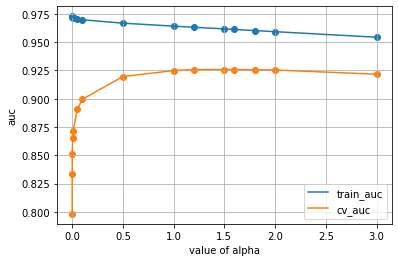

In [53]:
plt.plot(alpha,train_auc,label='train_auc')
plt.plot(alpha,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(alpha,train_auc)
plt.scatter(alpha,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of alpha')
plt.show()

#### from alpha 1.0  to  2.0 work well after that validation score is reducing

### computing accuracy using gridSearchCV 

In [80]:
from sklearn.model_selection import GridSearchCV
model=MultinomialNB()
parameters = {'alpha':[0.0001,0.001,0.1,0.50,0.51,0.55,0.69,0.9,1.5]}
clf = GridSearchCV(model, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(x_train_bow, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.5, 0.51, 0.55, 0.69,
                                   0.9, 1.5]},
             return_train_score=True, scoring='roc_auc')

In [81]:
train_auc= clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']
print(len(train_auc))
print(len(cv_auc))

9
9


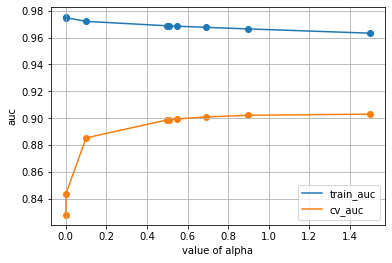

In [84]:
alpha=[0.0001,0.001,0.1,0.50,0.51,0.55,0.69,0.9,1.5]
plt.plot(alpha,train_auc,label='train_auc')
plt.plot(alpha,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(alpha,train_auc)
plt.scatter(alpha,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of alpha')
plt.show()

#### best alpha is 1.0 from this graph

### plotting the roc_auc curve

In [86]:
y_train_pred=[]
y_test_pred=[]
best_alpha=1.0
clf=MultinomialNB(alpha=best_alpha)
clf.fit(x_train_bow,y_train)
y_train_pred.extend(clf.predict_proba(x_train_bow)[:,1])
y_test_pred.extend(clf.predict_proba(x_test_bow)[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
fpr_test,tpr_test,thresholds_train=roc_curve(y_test,y_test_pred)

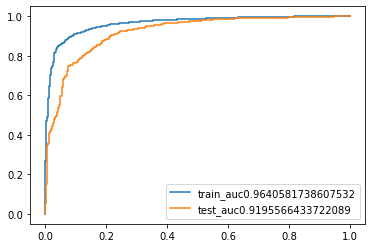

In [87]:
plt.plot(fpr_train,tpr_train,label='train_auc'+str(auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='test_auc'+str(auc(fpr_test,tpr_test)))
plt.legend()

### Confusion Matrix

In [90]:
from sklearn.metrics import confusion_matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,clf.predict(x_train_bow)))
print('Test Confusion Matrix')
print(confusion_matrix(y_test,clf.predict(x_test_bow)))

Train Confusion Matrix
[[ 788  200]
 [ 235 4801]]
Test Confusion Matrix
[[ 328  163]
 [ 122 2257]]


### Confusion Matrix of Train data

<AxesSubplot:>

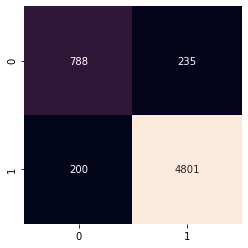

In [92]:
import seaborn as sns
mat=confusion_matrix(y_train,clf.predict(x_train_bow))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

### Confusion Matrix of Train data

<AxesSubplot:>

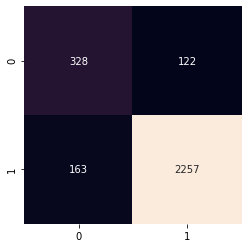

In [94]:
# pythondatascience handbook o'reilly book
mat=confusion_matrix(y_test,clf.predict(x_test_bow))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [102]:
clf=MultinomialNB(alpha=1.0)
clf.fit(x_train_bow,y_train)

MultinomialNB()

In [105]:
feature_prob=[] #store probability of feature
feature_names=[] #store feature names
for cur_feature in range(x_train_bow.shape[1]):
    feature_prob.append(clf.feature_log_prob_[1,cur_feature])#collecting only postive feature probability
def feature_append(data):
    """Getting Features from data for probability"""
    for a in data:
        feature_names.append(a)

feature_append(bow_feature_name)
print(len(feature_prob))
print(len(feature_names))

2562
2562


In [106]:
bow_feature=pd.DataFrame({'feature_prob':feature_prob,'feature_names':feature_names})
sorted_feature=bow_feature.sort_values(by=['feature_prob'])

In [107]:
sorted_feature.head(20) #Top 20 positive word/categorical feature

,feature_prob,feature_names
913,-10.901278,garbage
774,-10.901278,expired
1082,-10.901278,hopes
1865,-10.613596,risk
600,-10.613596,dented
579,-10.613596,dead
1813,-10.613596,refund
1397,-10.613596,misleading
640,-10.390453,disappointing
637,-10.390453,dirt


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [108]:
clf=MultinomialNB(alpha=1.0)
clf.fit(x_train_bow,y_train)
feature_prob=[] #store probability of feature
feature_names=[] #store feature names
for cur_feature in range(x_train_bow.shape[1]):
    feature_prob.append(clf.feature_log_prob_[0,cur_feature])#collecting only postive feature probability
def feature_append(data):
    """Getting Features from data for probability"""
    for a in data:
        feature_names.append(a)
feature_append(bow_feature_name)
print(len(feature_prob))
print(len(feature_names))

2562
2562


In [109]:
bow_feature=pd.DataFrame({'feature_prob':feature_prob,'feature_names':feature_names})
sorted_feature=bow_feature.sort_values(by=['feature_prob'])
sorted_feature.head(20) #Top 20 negative words/categories feature

,feature_prob,feature_names
431,-10.568775,coats
150,-10.568775,balls
1866,-10.568775,riviera
1867,-10.568775,road
1065,-10.568775,hits
611,-10.568775,desserts
1072,-10.568775,holidays
2271,-10.568775,tend
1078,-10.568775,hooked
1359,-10.568775,mellow


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [110]:
print(final_sorted_data.shape)
print(type(final_sorted_data))

(9564, 11)
<class 'pandas.core.frame.DataFrame'>


In [111]:
X=final_sorted_data['preprocessed_reviews']
Y=final_sorted_data['Score']

### Splitting into train,cv and test sets

#### from sklearn.model_selection import train_test_split
#### This will not work because train_test_split() splits data randomly. What we want is a time-based splitting on
#### the dataset that we have sorted chronologically
#### X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [112]:
print(X.shape)
print(Y.shape)
print(type(Y))

(9564,)
(9564,)
<class 'pandas.core.series.Series'>


In [ ]:
#function to split dataset into train and test datasets
'''
def train_test_splitter(X, y, test_size):
    train_size = 1 - test_size
    train_row_upper_index = round(train_size*X.shape[0])
    test_row_lower_index = train_row_upper_index + 1
    
    #print(train_row_upper_index)
    
    X_train = X[:train_row_upper_index + 1, :]
    X_test = X[test_row_lower_index:, :]
    Y_train = y.iloc[:train_row_upper_index + 1]
    Y_test = y.iloc[test_row_lower_index:]
    
    return X_train, X_test, Y_train, Y_test 
'''

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_splitter(X, Y, test_size = 0.20)

In [ ]:
'''
print(type(X_train))
print(X_train.shape[0] + X_test.shape[0])
'''

In [114]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.1,random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(6024,)
(6024,)
(2870,)
(2870,)
(670,)
(670,)


In [115]:
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [156]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
def tfidf(data):
    text_bow = tf_idf_vect.transform(data)
    return text_bow

tf_idf_vect.fit(x_train)
x_train_tfidf=tfidf(x_train)
x_test_tfidf=tfidf(x_test)
x_cv_tfidf=tfidf(x_cv)
tfidf_feature_name=tf_idf_vect.get_feature_names()

In [157]:
print(x_train_tfidf.shape)
len(tfidf_feature_name)

(6024, 3793)


3793

In [126]:
print(x_train_tfidf.shape)
print(x_cv_tfidf.shape)
print(x_test_tfidf.shape)

(6024, 3793)
(670, 3793)
(2870, 3793)


#### 5.1.1.2. Training and Testing

In [127]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [128]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
alpha=[0.00000001,0.0001,0.001,0.005,0.010,0.05,0.1,0.5,1,1.2,1.5,1.6,1.8,2,3]
y_train_pred=[]
y_cv_pred=[]
train_auc=[]
cv_auc=[]
for a in tqdm(alpha):
    y_train_pred=[]
    y_cv_pred=[]
    model=MultinomialNB(alpha=a)
    model.fit(x_train_tfidf,y_train)
    y_train_pred.extend(model.predict_proba(x_train_tfidf)[:,1])
    y_cv_pred.extend(model.predict_proba(x_cv_tfidf)[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.76it/s]


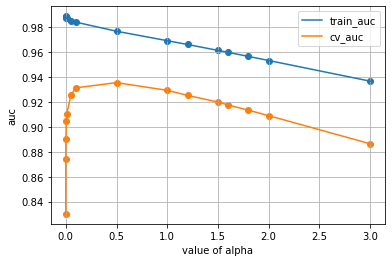

In [129]:
plt.plot(alpha,train_auc,label='train_auc')
plt.plot(alpha,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(alpha,train_auc)
plt.scatter(alpha,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of alpha')
plt.show()

#### from alpha 1.0  to  2.0 work well after that validation score is reducing

#### computing accuracy using gridSearchCV

In [132]:
from sklearn.model_selection import GridSearchCV
model=MultinomialNB()
parameters = {'alpha':[0.0001,0.001,0.1,0.50,0.51,0.55,0.69,0.9,1.5]}
clf = GridSearchCV(model, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(x_train_tfidf, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.5, 0.51, 0.55, 0.69,
                                   0.9, 1.5]},
             return_train_score=True, scoring='roc_auc')

In [133]:
train_auc= clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']
print(len(train_auc))
print(len(cv_auc))

9
9


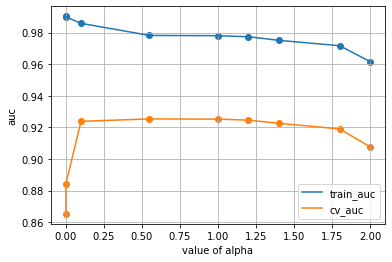

In [138]:
alpha=[0.0001,0.001,0.1,0.55,1.0,1.2,1.4,1.8,2.0]
plt.plot(alpha,train_auc,label='train_auc')
plt.plot(alpha,cv_auc,label='cv_auc')
plt.legend()
plt.scatter(alpha,train_auc)
plt.scatter(alpha,cv_auc)
plt.grid()
plt.ylabel('auc')
plt.xlabel('value of alpha')
plt.show()

#### best alpha is 1.0 from this graph

#### plotting the roc_auc curve

In [140]:
y_train_pred=[]
y_test_pred=[]
best_alpha=1.0
clf=MultinomialNB(alpha=best_alpha)
clf.fit(x_train_tfidf,y_train)
y_train_pred.extend(clf.predict_proba(x_train_tfidf)[:,1])
y_test_pred.extend(clf.predict_proba(x_test_tfidf)[:,1])
fpr_train,tpr_train,thresholds_train=roc_curve(y_train,y_train_pred)
fpr_test,tpr_test,thresholds_train=roc_curve(y_test,y_test_pred)

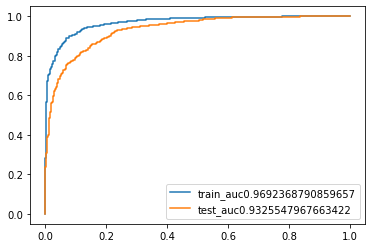

In [141]:
plt.plot(fpr_train,tpr_train,label='train_auc'+str(auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='test_auc'+str(auc(fpr_test,tpr_test)))
plt.legend()

### Confusion Matrix

In [144]:
from sklearn.metrics import confusion_matrix
print('Train Confusion Matrix')
print(confusion_matrix(y_train,clf.predict(x_train_tfidf)))
print('Test Confusion Matrix')
print(confusion_matrix(y_test,clf.predict(x_test_tfidf)))

Train Confusion Matrix
[[ 225  763]
 [   8 5028]]
Test Confusion Matrix
[[  68  423]
 [   1 2378]]


### Confusion Matrix of Train data

<AxesSubplot:>

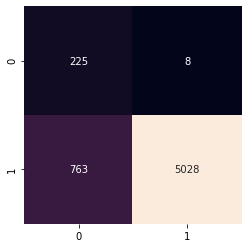

In [147]:
import seaborn as sns
mat=confusion_matrix(y_train,clf.predict(x_train_tfidf))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

### Confusion Matrix of Test data

<AxesSubplot:>

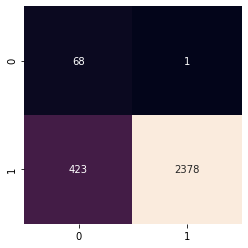

In [150]:
# pythondatascience handbook o'reilly book
mat=confusion_matrix(y_test,clf.predict(x_test_tfidf))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [151]:
clf=MultinomialNB(alpha=1.0)
clf.fit(x_train_tfidf,y_train)

MultinomialNB()

In [158]:
feature_prob=[] #store probability of feature
feature_names=[] #store feature names
for cur_feature in range(x_train_tfidf.shape[1]):
    feature_prob.append(clf.feature_log_prob_[1,cur_feature])#collecting only postive feature probability
def feature_append(data):
    """Getting Features from data for probability"""
    for a in data:
        feature_names.append(a)

feature_append(tfidf_feature_name)
print(len(feature_prob))
print(len(feature_names))

3793
3793


In [159]:
tfidf_feature=pd.DataFrame({'feature_prob':feature_prob,'feature_names':feature_names})
sorted_feature=tfidf_feature.sort_values(by=['feature_prob'])

In [160]:
sorted_feature.head(20) #Top 20 positive word/categorical feature

,feature_prob,feature_names
1535,-10.174604,high hopes
2715,-10.043384,really wanted
1276,-9.996365,garbage
1564,-9.985591,hopes
1333,-9.935779,going back
2259,-9.924624,not waste
1040,-9.910574,expired
859,-9.907391,disappointed product
2534,-9.883206,positive reviews
2750,-9.867579,refund


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [162]:
clf=MultinomialNB(alpha=1.0)
clf.fit(x_train_tfidf,y_train)
feature_prob=[] #store probability of feature
feature_names=[] #store feature names
for cur_feature in range(x_train_tfidf.shape[1]):
    feature_prob.append(clf.feature_log_prob_[0,cur_feature])#collecting only postive feature probability
def feature_append(data):
    """Getting Features from data for probability"""
    for a in data:
        feature_names.append(a)
feature_append(tfidf_feature_name)
print(len(feature_prob))
print(len(feature_names))

3793
3793


In [163]:
bow_feature=pd.DataFrame({'feature_prob':feature_prob,'feature_names':feature_names})
sorted_feature=bow_feature.sort_values(by=['feature_prob'])
sorted_feature.head(20) #Top 20 negative words/categories feature

,feature_prob,feature_names
1545,-9.086126,hits
1510,-9.086126,hearty
1054,-9.086126,fair trade
3201,-9.086126,sturdy
2169,-9.086126,not bitter
1060,-9.086126,family friends
1061,-9.086126,family loves
1523,-9.086126,hemp
1944,-9.086126,makes perfect
1300,-9.086126,gevalia


# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table=PrettyTable()
table.field_names=['vectorize','HyperParameter(Alpha)','AUC-Train','AUC-Test']
table.add_row(['BOW',"0.5","0.78","0.70"])
table.add_row(['TFIDF',"0.66","0.78","0.70"])